In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-11-13 18:16:36.419472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 18:16:36.428464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 18:16:36.431290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth enabled for the first GPU.")
    except RuntimeError as e:
        print(f"Could not enable memory growth: {e}")
else:
    print("No GPUs found.")

Memory growth enabled for the first GPU.


I0000 00:00:1731539809.137828  996961 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731539809.164178  996961 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731539809.167599  996961 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1',
           '', 'trans2', '', 'M_chirp_det', 'q', 'z_cdf']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = ['I1', 'I2']

# Define file directory and load data
dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

# Prepare X, Y, Z based on loaded data
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]

# Transpose X and Y to shape (nrows, ncols)
X, Y = X.T, Y.T

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

# Fit-transform X
x = scaler_X.fit_transform(X)
y = scaler_Y.fit_transform(Y)

# Split the data for training and validation as required
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

In [4]:
model = tf.keras.models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(x_ncols,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(y_ncols, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse')
model.summary()

batch_size = 128
num_epochs = 1000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

/home/anik/mconda3/envs/tfg/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731539964.174485  996961 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731539964.178880  996961 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731539964.180814  996961 cuda_executor.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,898 (19.13 KB)

 Trainable params: 4,898 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
training = model.fit(x_tr, y_tr, epochs=1000, validation_data=(x_ts, y_ts), \
                          batch_size=128, callbacks=[stop_early, lr_schedule])

Epoch 1/1000


I0000 00:00:1731539987.333415  997268 service.cc:146] XLA service 0x751e840059c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731539987.333441  997268 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9


 3/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0326  s: 0.0316

I0000 00:00:1731539988.708334  997268 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0204 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.0061 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.0026 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0017 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.0012 - val_loss: 9.9975e-04 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 8.2370e-04 - val_loss: 7.2521e-04 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 6.5945e-04 - val_loss: 5.4651e-04 - learning_rate: 0.0010
Epoch 8/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 5.1469e-04 - val_loss: 4.8469e-04 - learning_rate: 0.0010
Epoch 9/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 4.6439e-04 - val_loss: 4.173

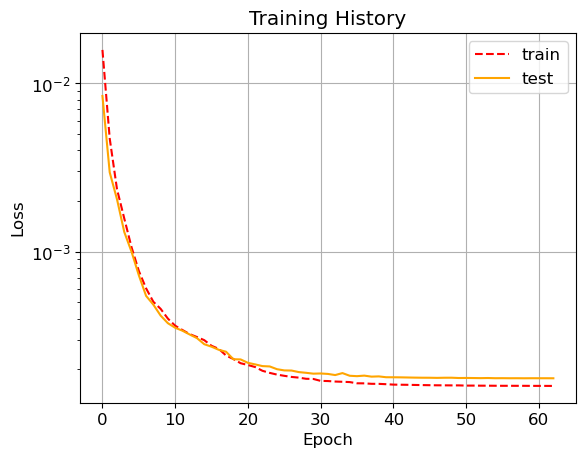

In [6]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


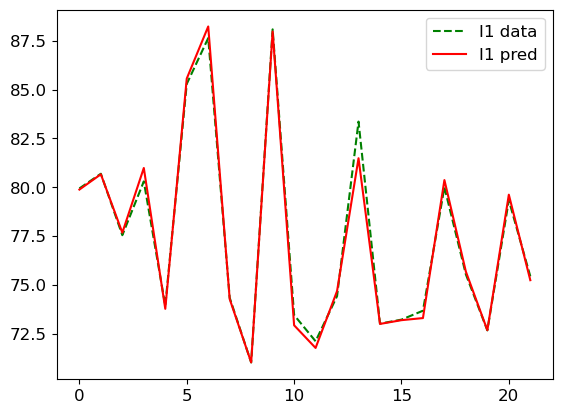

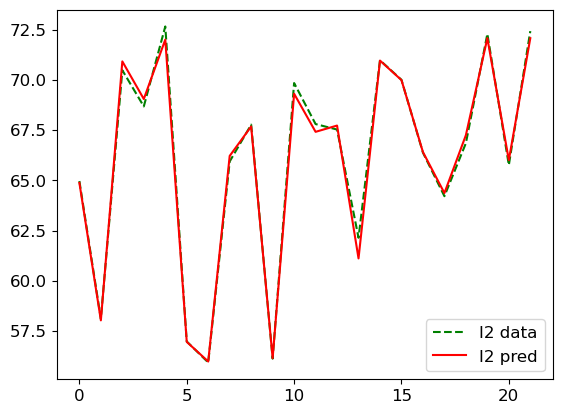

In [8]:
y_pr = model.predict(x_vl)

# Initialize arrays to store denormalized values
Y_pr = scaler_Y.inverse_transform(y_pr)
Y_vl = scaler_Y.inverse_transform(y_vl)

# Plot the results
plt.plot(Y_vl[:, 0], label='I1 data', c='g', ls='--')
plt.plot(Y_pr[:, 0], label='I1 pred', c='r')
plt.legend()
plt.show()

plt.plot(Y_vl[:, 1], label='I2 data', c='g', ls='--')
plt.plot(Y_pr[:, 1], label='I2 pred', c='r')
plt.legend()
plt.show()
